In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report, f1_score

### Exploration

In [4]:
df = pd.read_csv("train.csv")

In [5]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
df.is_duplicate.value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [7]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [8]:
questions = pd.concat([df.question1, df.question2])
questions.astype('str').apply(len).mean()

59.82254817086745

11

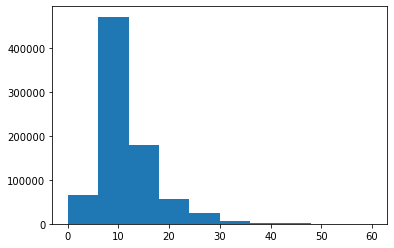

In [9]:
def mean_word_count(series):
    lenlist = []
    for sentence in series.astype('str'):
        words = sentence.split()
        lenlist.append(len(words))
    plt.hist(lenlist, range=(0, 60))
    return sum(lenlist) // len(lenlist)

mean_word_count(questions)

In [10]:
df[df['is_duplicate'] == 1].head()

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [11]:
df[df['is_duplicate'] == 0].head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Data Cleaning

In [12]:
def preprocess(series):
    res = []
    for document in series.astype('str'):
        # remove punctuation
        document = document.translate(str.maketrans('', '', string.punctuation))
        # convert to lowercase
        document = document.lower()
        # remove leading and trailing spaces
        document = document.strip()
        # tokenize        
        tokens = word_tokenize(document)
        # lemmatize and remove stopwords/non-alpha words
        lemmatizer = WordNetLemmatizer()
        res_tokens = [lemmatizer.lemmatize(token) for token in tokens if (not token in stop_words) and (token.isalpha() == True)]
        # append to return list
        res.append(' '.join(res_tokens))
    return pd.Series(res)

In [13]:
# apply preprocess function
df['question1'] = preprocess(df.question1)
df['question2'] = preprocess(df.question2)

In [14]:
# drop ID columns
df.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)

In [15]:
# above is time intensive, so let's save it off
df.to_csv('preprocessed.csv')

### Feature Engineering - tf-idf

In [16]:
# pipeline for tfidf transformation

transformer = FeatureUnion([
                ('q1_tfidf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['question1'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())])),
                ('q2_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['question2'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer())]))]) 

In [17]:
X = transformer.fit_transform(df[['question1', 'question2']])

In [18]:
y = df.is_duplicate

In [19]:
q1_vocab = transformer.transformer_list[0][1].steps[1][1].get_feature_names() 
q2_vocab = transformer.transformer_list[1][1].steps[1][1].get_feature_names()
vocab = q1_vocab + q2_vocab
len(vocab)

C:\Users\monol\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


128737

In [20]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=808)

### Modeling - Base Model

#### Random Forest

In [21]:
clf = RandomForestClassifier(n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 14.9min finished


RandomForestClassifier(n_jobs=-1, verbose=1)

In [22]:
y_pred = clf.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.5s finished


In [23]:
print(classification_report(y_pred, y_test, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86     71577
           1       0.65      0.82      0.72     29496

    accuracy                           0.82    101073
   macro avg       0.78      0.82      0.79    101073
weighted avg       0.84      0.82      0.82    101073



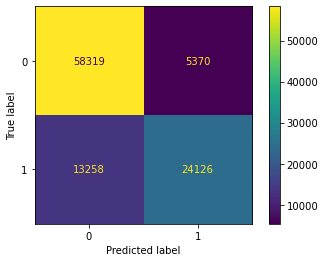

In [24]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()

In [25]:
accuracy_score(y_test, y_pred)

0.815697565126196

#### Random Forest - Optimized

In [26]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 500],
    }

In [27]:
rf = RandomForestClassifier(n_jobs=-1)

In [28]:
clf = GridSearchCV(rf, param_grid, verbose=2)

In [29]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=3, n_estimators=100; total time=   2.9s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.7s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.9s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.9s
[CV] END ......................max_depth=3, n_estimators=100; total time=   1.7s
[CV] END ......................max_depth=3, n_estimators=200; total time=   3.2s
[CV] END ......................max_depth=3, n_estimators=200; total time=   3.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=   3.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=   3.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=   3.4s
[CV] END ......................max_depth=3, n_estimators=500; total time=   8.4s
[CV] END ......................max_depth=3, n_est

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500]},
             verbose=2)

In [30]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.083046,0.434564,0.069902,0.002888,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.631027,0.631027,0.631021,0.631021,0.631037,0.631027,0.000006,2
1,3.271890,0.047933,0.122698,0.003869,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.631027,0.631027,0.631021,0.631021,0.631037,0.631027,0.000006,2
2,8.099024,0.197542,0.288700,0.009990,3,500,"{'max_depth': 3, 'n_estimators': 500}",0.631027,0.631027,0.631021,0.631021,0.631037,0.631027,0.000006,2
3,2.840567,0.103534,0.072661,0.008470,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.631027,0.631027,0.631021,0.631021,0.631037,0.631027,0.000006,2
4,5.365433,0.081630,0.118959,0.003988,5,200,"{'max_depth': 5, 'n_estimators': 200}",0.631027,0.631027,0.631021,0.631021,0.631037,0.631027,0.000006,2
5,12.230533,0.050179,0.290104,0.015516,5,500,"{'max_depth': 5, 'n_estimators': 500}",0.631027,0.631027,0.631021,0.631021,0.631037,0.631027,0.000006,2
6,3.764370,0.149981,0.068796,0.003328,7,100,"{'max_depth': 7, 'n_estimators': 100}",0.631109,0.631027,0.631021,0.631021,0.631037,0.631043,0.000034,1
7,7.175030,0.146681,0.120797,0.006433,7,200,"{'max_depth': 7, 'n_estimators': 200}",0.631027,0.631027,0.631021,0.631021,0.631037,0.631027,0.000006,2
8,16.499207,0.197870,0.276410,0.009123,7,500,"{'max_depth': 7, 'n_estimators': 500}",0.631027,0.631027,0.631021,0.631021,0.631037,0.631027,0.000006,2


In [31]:
clf.best_score_

0.6310431141717837

In [32]:
y_pred = clf.predict(X_test)

In [33]:
print(classification_report(y_pred, y_test, target_names=['0','1']))

              precision    recall  f1-score   support

           0       1.00      0.63      0.77    101073
           1       0.00      0.00      0.00         0

    accuracy                           0.63    101073
   macro avg       0.50      0.32      0.39    101073
weighted avg       1.00      0.63      0.77    101073



C:\Users\monol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\monol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\monol\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


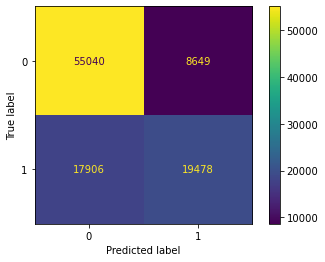

In [34]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()

#### Naive Bayes

In [21]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [22]:
y_pred = clf.predict(X_test)

In [23]:
print(classification_report(y_pred, y_test, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.86      0.76      0.80     72091
           1       0.53      0.69      0.60     28982

    accuracy                           0.74    101073
   macro avg       0.69      0.72      0.70    101073
weighted avg       0.76      0.74      0.75    101073



In [24]:
roc_auc_score(y_test, y_pred)

0.6949844002072222

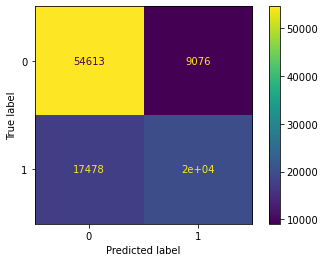

In [25]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()

#### Naive Bayes - Optimized

In [26]:
param_grid = {'alpha': [1.1, 1.2, 1.3]}

In [27]:
mnb = MultinomialNB()

In [28]:
clf = GridSearchCV(mnb, param_grid, verbose=2)

In [29]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.1; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.2; total time=   0.0s
[CV] END ..........................................alpha=1.3; total time=   0.0s
[CV] END ........................................

GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha': [1.1, 1.2, 1.3]},
             verbose=2)

In [30]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.060136,0.004137,0.008439,0.001041,1.1,{'alpha': 1.1},0.734566,0.735984,0.733308,0.736392,0.733885,0.734827,0.001187,3
1,0.058785,0.001705,0.008608,0.000716,1.2,{'alpha': 1.2},0.734747,0.735522,0.733770,0.737117,0.733770,0.734985,0.001253,1
2,0.058056,0.002919,0.007715,0.000398,1.3,{'alpha': 1.3},0.734698,0.735473,0.733654,0.737200,0.733885,0.734982,0.001281,2


In [31]:
clf.best_score_

0.734985174647984

In [32]:
y_pred = clf.predict(X_test)

In [33]:
print(classification_report(y_pred, y_test, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.86      0.75      0.81     72946
           1       0.52      0.69      0.59     28127

    accuracy                           0.74    101073
   macro avg       0.69      0.72      0.70    101073
weighted avg       0.77      0.74      0.75    101073



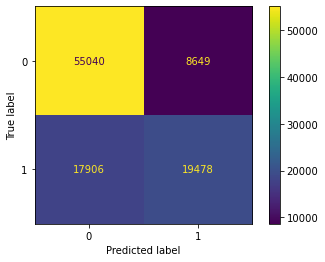

In [34]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()

#### Logistic Regression

In [49]:
clf = LogisticRegression(max_iter=10000, C=0.8)
clf.fit(X_train, y_train)

LogisticRegression(C=0.8, max_iter=10000)

In [50]:
y_pred = clf.predict(X_test)

In [51]:
print(classification_report(y_pred, y_test, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82     73155
           1       0.54      0.72      0.62     27918

    accuracy                           0.75    101073
   macro avg       0.71      0.74      0.72    101073
weighted avg       0.78      0.75      0.76    101073



In [52]:
roc_auc_score(y_test, y_pred)

0.707879716978937

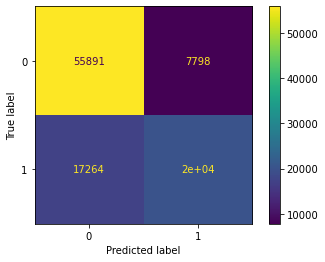

In [53]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()

#### Logistic Regression - Optimized

In [40]:
param_grid = {
    'penalty': ['l1','l2']
}    

In [41]:
lr = LogisticRegression(max_iter=10000, C=0.8)

In [42]:
clf = GridSearchCV(lr, param_grid, verbose=2, n_jobs=-1)

In [43]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\monol\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\monol\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\monol\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\monol\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueE

GridSearchCV(estimator=LogisticRegression(C=0.8, max_iter=10000), n_jobs=-1,
             param_grid={'penalty': ['l1', 'l2']}, verbose=2)

In [44]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047163,0.004755,0.000000,0.000000,l1,{'penalty': 'l1'},NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,12.410634,1.047620,0.007218,0.001696,l2,{'penalty': 'l2'},0.750544,0.749934,0.750276,0.751117,0.750111,0.750397,0.000413,1


In [45]:
clf.best_score_

0.7503965817053884

In [46]:
print(classification_report(y_pred, y_test, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82     72665
           1       0.55      0.72      0.62     28408

    accuracy                           0.75    101073
   macro avg       0.71      0.74      0.72    101073
weighted avg       0.78      0.75      0.76    101073



In [47]:
roc_auc_score(y_test, y_pred)

0.7095090404384102

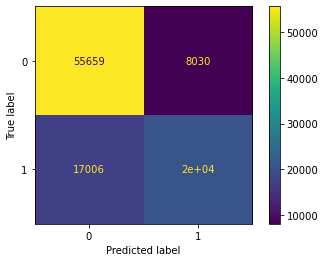

In [48]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()

#### XGBoost

In [54]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
y_pred = clf.predict(X_test)

In [56]:
print(classification_report(y_pred, y_test, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82     81323
           1       0.41      0.78      0.54     19750

    accuracy                           0.74    101073
   macro avg       0.67      0.76      0.68    101073
weighted avg       0.83      0.74      0.76    101073



In [57]:
roc_auc_score(y_test, y_pred)

0.6730724403631805

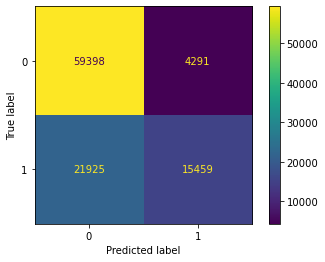

In [58]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()

#### XGBoost - Optimized

In [59]:
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth' : [10, 12],
}    

In [60]:
xgbc = xgb.XGBClassifier(n_jobs=-1)

In [61]:
clf = GridSearchCV(xgbc, param_grid, verbose=2)

In [62]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:50:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=10, n_estimators=500; total time= 1.3min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=10, n_estimators=500; total time= 1.3min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=10, n_estimators=500; total time= 1.3min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:54:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=10, n_estimators=500; total time= 1.3min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:55:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=10, n_estimators=500; total time= 1.3min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:56:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=10, n_estimators=1000; total time= 2.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=10, n_estimators=1000; total time= 2.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:01:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=10, n_estimators=1000; total time= 2.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=10, n_estimators=1000; total time= 2.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=10, n_estimators=1000; total time= 2.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=12, n_estimators=500; total time= 1.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=12, n_estimators=500; total time= 1.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=12, n_estimators=500; total time= 1.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:13:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=12, n_estimators=500; total time= 1.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END .....................max_depth=12, n_estimators=500; total time= 1.5min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=12, n_estimators=1000; total time= 2.9min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=12, n_estimators=1000; total time= 2.9min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:22:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=12, n_estimators=1000; total time= 2.9min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:25:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=12, n_estimators=1000; total time= 2.9min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:28:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END ....................max_depth=12, n_estimators=1000; total time= 2.9min


C:\Users\monol\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
              

In [63]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,77.111720,0.671042,0.262074,0.017930,10,500,"{'max_depth': 10, 'n_estimators': 500}",0.779813,0.778214,0.779810,0.781129,0.781178,0.780029,0.001088,4
1,150.046401,0.644471,0.557376,0.023408,10,1000,"{'max_depth': 10, 'n_estimators': 1000}",0.789740,0.789114,0.789324,0.790330,0.790594,0.789820,0.000568,2
2,89.916690,0.916912,0.303714,0.008443,12,500,"{'max_depth': 12, 'n_estimators': 500}",0.783491,0.784167,0.783817,0.786125,0.784872,0.784494,0.000936,3
3,175.393474,0.192285,0.631628,0.022146,12,1000,"{'max_depth': 12, 'n_estimators': 1000}",0.792593,0.792181,0.793200,0.795096,0.794453,0.793504,0.001105,1


In [64]:
clf.best_score_

0.7935043293589307

In [65]:
clf.best_params_

{'max_depth': 12, 'n_estimators': 1000}

In [66]:
y_pred = clf.predict(X_test)

In [67]:
print(classification_report(y_pred, y_test, target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85     71689
           1       0.62      0.79      0.70     29384

    accuracy                           0.80    101073
   macro avg       0.76      0.80      0.77    101073
weighted avg       0.82      0.80      0.80    101073



In [68]:
roc_auc_score(y_test, y_pred)

0.7619357867913117

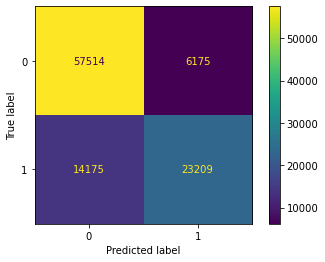

In [69]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
disp.plot()

In [70]:
accuracy_score(y_test, y_pred)

0.798660374184995